In [205]:
import json
import math, os
import networkx as nx
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import random

In [206]:
class Layer:
    def __init__(self, neurons: list, type: str, activFun: str):
        self.neurons = neurons
        self.type = type
        self.activ_fun = activFun


    def addNeuron(self, neuron):
        self.neurons.append(neuron)


In [207]:



class Neuron:
    def __init__(self, layer: Layer, weight: list,):
        self.layer= layer
        self.weight= weight
        self.temp_weight= self.weight[:]
        self.net= 0.0
        self.value = 0.0
        self.err = 0.0

    def activate(self):
        activation_functions = {
            "linear": lambda self: self.net,
            "relu": lambda self: max(0, self.net),
            "sigmoid": lambda self: 1 / (1 + math.exp(-self.net)),
        }
        if self.layer.activ_fun == 'softmax':
            try:
                layerNeurons: list = self.layer.neurons
                expSum: float = 0.0

                for neuron in layerNeurons:
                    expSum += math.exp(neuron.net)

                self.value = math.exp(self.net) / expSum
            except Exception as e:
                self.value = 0.0
        else:
            self.value = activation_functions[self.layer.activ_fun](self)

    def softmax(self):          
        try:
            layerNeurons: list = self.layer.neurons
            expSum: float = 0.0

            for neuron in layerNeurons:
                expSum += math.exp(neuron.net)

            self.value = math.exp(self.net) / expSum
        except Exception as e:
            self.value = 0.0



In [208]:
class NeuralNetwork:
    def __init__(self, config, model, input, initialWeights, target, learningParameter):
        self.config = config
        self.model = model
        self.input = input
        self.initialWeights = initialWeights
        self.target = target
        self.learningParameter = learningParameter
        self.layers: list[Layer] = []
        self.buildNeuralNetwork()

    def buildNeuralNetwork(self):

        inputLayer = Layer([], "input", "")
        inputSize = self.model["input_size"]
        for i in range(inputSize):
            neuron = self.generateNeuronData(inputLayer, {"weights": []})
            inputLayer.addNeuron(neuron)
        self.layers.append(inputLayer)

        layers = self.model["layers"]
        for i, layer in enumerate(layers):
            layerType = "hidden"
            if i == len(layers) - 1:
                layerType = "output"

            currLayer = Layer([], layerType, layer["activation_function"])
            layerWeights = self.initialWeights[i]
            for j in range(layer["number_of_neurons"]):
                neuronWeights = []
                for k in range(len(layerWeights)):
                    neuronWeights.append(layerWeights[k][j])
                neuron = self.generateNeuronData(currLayer, {"weights": neuronWeights})
                currLayer.addNeuron(neuron)

            self.layers.append(currLayer)
        
        return

    def generateNeuronData(self, layer: Layer, neuron_data):
        weights: list = []

        if (layer.type == "hidden" or layer.type == "output"):
            weights = neuron_data["weights"]

        return Neuron(layer, weights)
    
    def forwardpropagation(self, input_data: list[float]):
        for i in range(len(input_data)):
            neuron = self.layers[0].neurons[i]
            neuron.value = input_data[i]

        for i, layer in enumerate(self.layers):
            if layer.type != "input":
                prevLayer = self.layers[i - 1]

                for neuron in layer.neurons:
                    total = neuron.weight[0]

                    prevNeurons: list[Neuron] = prevLayer.neurons
                    for i, prevNeuron in enumerate(prevNeurons):
                        total += prevNeuron.value * neuron.weight[i + 1]

                    neuron.net=total
        
                for neuron in layer.neurons:
                    neuron.activate()

        return
    
    def backpropagation(self, target_data: list[float], update = False):
        outputLayer: Layer = self.layers[len(self.layers) - 1]
        outputNeurons: list[Neuron] = outputLayer.neurons
        for x, outputNeuron in enumerate(outputNeurons):
            dedDnetX = 0.0
            
            oX = outputNeuron.value
            dedDoX = -1 * (target_data[x] - oX)
            doXDnetX = 0.0
            activFun = outputLayer.activ_fun
            activation_derivatives = {
                "linear": lambda oX,net: 1.0,
                "relu": lambda oX, net: 1.0 if net >= 0.0 else 0.0,
                "sigmoid": lambda oX,net: oX * (1 - oX),
                "softmax": lambda oX, target_data: -1 * (1 - oX) if target_data == 1.0 else oX
            }
            doXDnetX = activation_derivatives[activFun](oX, outputNeuron.net) if activFun != "softmax" else activation_derivatives[activFun](oX, target_data[x])

            if activFun != "softmax":
                dedDnetX = dedDoX * doXDnetX

            outputNeuron.err= -1 * dedDnetX
            pass

        for i in range(len(self.layers) - 2, -1, -1):
            currLayer: Layer = self.layers[i]
            if currLayer.type == "input":
                break

            curNeurons: list[Neuron] = currLayer.neurons
            nextLayer: Layer = self.layers[i + 1]
            nextNeuron: list[Neuron] = nextLayer.neurons
        
            for h, hidNeuron in enumerate(curNeurons):
                oh = hidNeuron.value
                dedDneth = 0.0
                dohDneth = 0.0
                activFun = currLayer.activ_fun
                activation_derivatives_hidden = {
                    "linear": lambda oh: 1.0,
                    "relu": lambda oh, net: 1.0 if net >= 0.0 else 0.0,
                    "sigmoid": lambda oh: oh * (1 - oh),
                    "softmax": lambda oh: oh
                }
                dohDneth = activation_derivatives_hidden[activFun](oh, hidNeuron.net) if activFun == "relu" else activation_derivatives_hidden[activFun](oh)

                for nextNeur in nextNeuron:
                    dedDnetk = -1 * nextNeur.err
                    dnetkDoh = nextNeur.weight[h + 1]
                    dedDneth += dedDnetk * dnetkDoh * dohDneth

                hidNeuron.err=(-1 * dedDneth)

        learningRate = self.learningParameter["learning_rate"]
        for i in range(len(self.layers) - 1, -1, -1):
            currLayer: Layer = self.layers[i]
            if currLayer.type == "input":
                break

            curNeurons: list[Neuron] = currLayer.neurons
            prevLayer: Layer = self.layers[i - 1]
            prevNeurons: list[Neuron] = prevLayer.neurons

            for neuron in curNeurons:
                weights: list[float] = neuron.weight

                for k in range(len(weights)):
                    xji = 1
                    
                    if k != 0:
                        xji = prevNeurons[k - 1].value

                    delta = learningRate * neuron.err * xji
                    neuron.temp_weight[k]= neuron.temp_weight[k] + delta

                    if update:
                        neuron.weight[k]= neuron.temp_weight[k]
        
        return
    
    def train(self):
        iter = 1

        maxIter = self.learningParameter["max_iteration"]
        batchSize = self.learningParameter["batch_size"]
        errorLimit = self.learningParameter["error_threshold"]
        inputs = len(self.input)

        index = 0
        processed = 0
        error = 0.0
        self.sum_delta_weight = 0

        while True:
            processed += 1

            inputVect = self.input[index]
            targetVect = self.target[index]
            self.forwardpropagation(inputVect)
            self.backpropagation(targetVect, processed % batchSize == 0)

            index += 1

            outputLayer: Layer = self.layers[len(self.layers) - 1]
            outputNeurons: list[Neuron] = outputLayer.neurons
            if outputLayer.activ_fun != "softmax":
                for i, neuron in enumerate(outputNeurons):
                    error += ((targetVect[i] - neuron.value) ** 2) / 2
            else:
                for i, neuron in enumerate(outputNeurons):
                    if targetVect[i] == 1.0:
                        error += -1 * np.log(neuron.value)

            if index >= inputs:
                print(f"Epoch: {iter} -> Error: {error}")
                
                if error <= errorLimit:
                    print("Error <= error threshold!")
                    break

                if iter >= maxIter:
                    print("Max iteration reached!")
                    break

                index = 0
                processed = 0
                error = 0.0
                iter += 1


    def show_weights(self):
        weights = []
        for layer in self.layers:
            if layer.type == "input":
                continue

            layerWeight = []
            for i in range(len(layer.neurons[0].weight)):
                levelWeight = []
                for neuron in layer.neurons:
                    levelWeight.append(neuron.weight[i])
                layerWeight.append(np.array(levelWeight, dtype=object))
            weights.append(np.array(layerWeight, dtype=object))
        
        print("\nFinal weights:")
        print(np.array(weights, dtype=object))

        if "expect" in self.config and "final_weights" in self.config["expect"]:
            sse = 0.0
            for i, _ in enumerate(self.config["expect"]["final_weights"]):
                for j, _ in enumerate(self.config["expect"]["final_weights"][i]):
                    for k, weight in enumerate(self.config["expect"]["final_weights"][i][j]):
                        sse += (weight - weights[i][j][k]) ** 2

            print(f"\nSSE compared to expected final_weights: {sse}")

    def predict_mlp(self, to_predict):
        self.forwardpropagation(to_predict)
        outputId = None
        max_val = None

        for i, neuron in enumerate(self.layers[len(self.layers) - 1].neurons):
            if outputId == None or neuron.value > max_val:
                outputId = i
                max_val = neuron.value

        return outputId
    
    def save(self, destination):
        weights = []
        for layer in self.layers:
            if layer.type == "input":
                continue

            layerWeight = []
            for i in range(len(layer.neurons[0].weight)):
                levelWeight = []
                for neuron in layer.neurons:
                    levelWeight.append(neuron.weight[i])
                layerWeight.append(levelWeight)
            weights.append(layerWeight)

        newModel = {
            "case": {
                "model": self.config["case"]["model"],
                "input": self.config["case"]["input"],
                "initial_weights": weights,
                "target": self.config["case"]["target"],
                "learning_parameters": self.config["case"]["learning_parameters"]
            }
        }

        jsonString = json.dumps(newModel)
        jsonFile = open(destination, "w")
        jsonFile.write(jsonString)
        jsonFile.close()

In [209]:
class Graph:
    def __init__(self, layers) -> None:
        self.layers = layers
    
    def draw(self,figsize=(6, 6)):
        G = nx.DiGraph()

        for i, layer in enumerate(self.layers):
            if i == 0:
                continue

            prevLayer = self.layers[i - 1]
            prevPrefix = ""
            prefix = ""

            if prevLayer.type == "input":
                prevPrefix = "X"
            elif prevLayer.type == "hidden":
                prevPrefix = f"H{i - 1}"
            else:
                prevPrefix = "O"
            
            if layer.type == "input":
                prefix = "X"
            elif layer.type == "hidden":
                prefix = f"H{i}"
            else:
                prefix = "O"


            for j in range (len(prevLayer.neurons)):
                for k, neuron in enumerate(layer.neurons):
                    G.add_edge(f"{prevPrefix}{j + 1}", f"{prefix}{k + 1}", weight=neuron.weight[j + 1])
            
        pos = {}
        currX = 0
        for i, layer in enumerate(self.layers):
            currY = 0

            prefix = ""
            if layer.type == "input":
                prefix = "X"
            elif layer.type == "hidden":
                prefix = f"H{i}"
            else:
                prefix = "O"
            
            for j in range(len(layer.neurons)):
                pos[f"{prefix}{j + 1}"] = (currX, currY)
                currY += 1

            currX += 1

        options = {
            "font_size": 12,
            "node_size": 500,
            "node_color": "white",
            "edgecolors": "black",
            "linewidths": 1,
            "width": 1,
        }

        _, ax = plt.subplots(figsize=figsize)
        nx.draw_networkx(G, pos, **options, ax=ax)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos, edge_labels, label_pos=0.6)

        ax = plt.gca()
        ax.margins(0.2)
        plt.axis("off")
        
    def show(self):
        plt.show()

Epoch: 1 -> Error: 8.237112801138153
Epoch: 2 -> Error: 8.237112801138153
Epoch: 3 -> Error: 8.237112801138153
Epoch: 4 -> Error: 8.237112801138153
Epoch: 5 -> Error: 8.237112801138153
Epoch: 6 -> Error: 8.237112801138153
Epoch: 7 -> Error: 8.237112801138153
Epoch: 8 -> Error: 8.237112801138153
Epoch: 9 -> Error: 8.237112801138153
Epoch: 10 -> Error: 8.237112801138153
Max iteration reached!

Final weights:
[[[0.1 0.9 -0.1]
  [-0.2 0.8 0.2]
  [0.3 -0.7 0.3]
  [0.4 0.6 -0.4]
  [0.5 0.5 0.5]
  [-0.6 0.4 0.6]
  [-0.7 -0.3 0.7]
  [0.8 0.2 -0.8]
  [0.9 -0.1 0.0]]]

SSE compared to expected final_weights: 0.5952445583506332


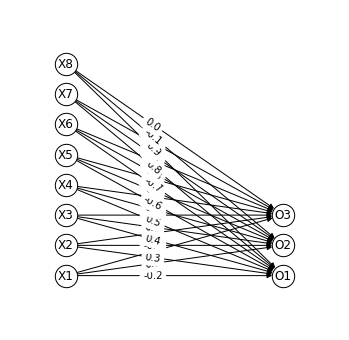

In [210]:
json_file = "Model/softmax.json"
with open (json_file, "r") as file:
    data = json.load(file)

learningParameter = data["case"]["learning_parameters"]
model = data["case"]["model"]
input = data["case"]["input"]
initialWeights = data["case"]["initial_weights"]
target = data["case"]["target"]

nn = NeuralNetwork(data, model, input, initialWeights, target, learningParameter)
graph = Graph(nn.layers)
graph.draw()
nn.train()
nn.show_weights()
nn.save("Model/save.json")
graph.show()

In [211]:
from sklearn import datasets

def generate_iris_to_train():
    iris = datasets.load_iris()
    model = {
        "case": {}
    }
    model["case"]["model"] = {
        "input_size": 4,
        "layers": [
            {
                "number_of_neurons": 8,
                "activation_function": "sigmoid"
            },
            {
                "number_of_neurons": 3,
                "activation_function": "sigmoid"
            }
        ]
    }

    model["case"]["input"] = iris.data.tolist()

    relu_weights = []
    for i in range(5):
        random_weight = [random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05),
                        random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05)]
        relu_weights.append(random_weight)
    softmax_weights = []
    for i in range(9):
        random_weight = [random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05), random.uniform(-0.05, 0.05)]
        softmax_weights.append(random_weight)
    model["case"]["initial_weights"] = []
    model["case"]["initial_weights"].append(relu_weights)
    model["case"]["initial_weights"].append(softmax_weights)

    model["case"]["target"] = []
    for target in iris.target:
        if target == 0:
            model["case"]["target"].append([1, 0, 0])
        elif target == 1:
            model["case"]["target"].append([0, 1, 0])
        else:
            model["case"]["target"].append([0, 0, 1])

    model["case"]["learning_parameters"] = {
        "learning_rate": 5e-3,
        "batch_size": 2,
        "max_iteration": 2000,
        "error_threshold": 0.1
    }
            
    jsonString = json.dumps(model)
    jsonFile = open("Model/iris.json", "w")
    jsonFile.write(jsonString)
    jsonFile.close()

generate_iris_to_train()

Epoch: 1 -> Error: 0.665
Max iteration reached!

Final weights:
[[[0.21999999999999997 0.36 0.10999999999999999]
  [0.64 0.30000000000000004 -0.8900000000000001]
  [0.28 -0.7 0.36999999999999994]]]

SSE compared to expected final_weights: 1.9451892438311082e-32


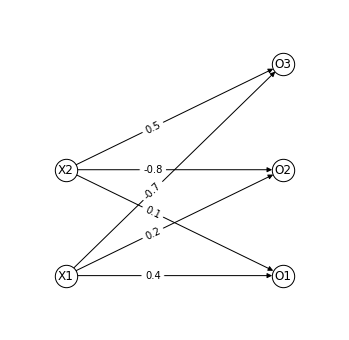

In [212]:
json_file = "Model/linear.json"
with open (json_file, "r") as file:
    data = json.load(file)

learningParameter = data["case"]["learning_parameters"]
model = data["case"]["model"]
input = data["case"]["input"]
initialWeights = data["case"]["initial_weights"]
target = data["case"]["target"]

nn = NeuralNetwork(data, model, input, initialWeights, target, learningParameter)
graph = Graph(nn.layers)
graph.draw()
nn.train()
nn.show_weights()
# nn.save("Model/saveiris.json")
graph.show()

In [213]:
nn.save("Model/saveiris.json")

In [214]:
json_file = "Model/saveiris.json"
with open (json_file, "r") as file:
    data = json.load(file)

learningParameter = data["case"]["learning_parameters"]
model = data["case"]["model"]
input = data["case"]["input"]
initialWeights = data["case"]["initial_weights"]
target = data["case"]["target"]

irisNN = NeuralNetwork(data, model, input, initialWeights, target, learningParameter)


In [215]:
from sklearn.neural_network import MLPClassifier

iris = datasets.load_iris()

X = iris.data
y = iris.target

mlp = MLPClassifier(hidden_layer_sizes=(8,), activation='logistic', solver='adam', max_iter=20000, learning_rate_init=5e-3)

mlp.fit(X, y)

print("Hidden layer weights:")
print(mlp.coefs_[0])

print("\nOutput layer weights:")
print(mlp.coefs_[1])

Hidden layer weights:
[[-0.14838205  0.9121027   0.78786993  0.98074426 -0.18457905  0.71558016
  -0.46514458 -1.01354326]
 [ 1.9120587   0.81388058  1.22068289  1.05431276 -0.88318889  1.18512148
  -0.68188076 -1.44374504]
 [-1.64693541 -1.36044271 -1.51406628 -1.58961607  1.36960253 -1.34485835
   1.62765943  1.8245968 ]
 [-1.28881467 -2.32848908 -1.93551424 -2.16735997  0.94514392 -2.06347535
   1.76319149  2.48064328]]

Output layer weights:
[[ 2.07576982 -1.57603144 -0.49086989]
 [ 1.49510907  0.98334122 -1.38812866]
 [ 1.09770255  0.79581914 -1.9187211 ]
 [ 1.25268371  1.19619624 -1.9545854 ]
 [-1.63083735  0.86878106  1.76455039]
 [ 1.23606026  0.65584633 -2.2607285 ]
 [-1.78435884  0.83615519  1.25575265]
 [-1.84810034 -1.47917534  1.53589922]]


In [216]:
print("\n=== Trained model without sklearn ===\n")
irisNN.show_weights()


=== Trained model without sklearn ===


Final weights:
[[[0.21999999999999997 0.36 0.10999999999999999]
  [0.64 0.30000000000000004 -0.8900000000000001]
  [0.28 -0.7 0.36999999999999994]]]


In [217]:
to_predict = [5.1, 3.5, 1.4, 0.2]
print(f"\n>>> Percobaan untuk memprediksi {to_predict}")
predicted = irisNN.predict_mlp(to_predict)

if predicted == 0:
    print("Setosa")
elif predicted == 1:
    print("Versicolor")
else:
    print("Virginica")

to_predict = [6.2, 2.8, 4.8, 1.8]
print(f"\n>>> Percobaan untuk memprediksi {to_predict}")
predicted = irisNN.predict_mlp(to_predict)

if predicted == 0:
    print("Setosa")
elif predicted == 1:
    print("Versicolor")
else:
    print("Virginica")


>>> Percobaan untuk memprediksi [5.1, 3.5, 1.4, 0.2]


IndexError: list index out of range

In [ ]:
print("\n=== Trained model using sklearn ===\n")
print(mlp.coefs_[0])
print(mlp.coefs_[1])


=== Trained model using sklearn ===

[[-0.99664263  0.26579825 -0.86525721  0.81857552  0.10472133  0.72211922
   0.26155369 -0.00535893]
 [-1.492542    0.93209774 -0.66637927  0.93274511 -1.43327723  0.99769427
   1.30488583 -1.14203649]
 [ 1.85469218 -0.89500478  1.37207453 -1.32931006  1.15864084 -1.48993095
  -1.79936444  1.30550983]
 [ 2.3571157  -1.21077988  2.12826689 -2.09720482  1.42390276 -1.38755949
  -1.75076028  0.8227889 ]]
[[-0.67833982 -1.43185053  1.84205359]
 [ 1.24917841  0.49983133 -1.58761732]
 [-0.16298017 -1.29495155  2.30909506]
 [ 1.59192577  1.40900652 -1.78848195]
 [-1.75522552  1.98393157  1.39138801]
 [ 0.91752057  0.97973004 -1.65187638]
 [ 1.8116986  -2.51983358 -0.66316422]
 [-1.15039493  1.35885066  0.94951862]]


In [ ]:
to_predict = [5.1, 3.5, 1.4, 0.2]
print(f"\n>>> Percobaan untuk memprediksi {to_predict}")
predicted = mlp.predict([to_predict])

if predicted == 0:
    print("Setosa")
elif predicted == 1:
    print("Versicolor")
else:
    print("Virginica")

to_predict = [6.2, 2.8, 4.8, 1.8]
print(f"\n>>> Percobaan untuk memprediksi {to_predict}")
predicted = mlp.predict([to_predict])

if predicted == 0:
    print("Setosa")
elif predicted == 1:
    print("Versicolor")
else:
    print("Virginica")
    
to_predict = [5.9,3.2,4.8,1.8]
print(f"\n>>> Percobaan untuk memprediksi {to_predict}")
predicted = irisNN.predict_mlp(to_predict)

if predicted == 0:
    print("Setosa")
elif predicted == 1:
    print("Versicolor")
else:
    print("Virginica")


>>> Percobaan untuk memprediksi [5.1, 3.5, 1.4, 0.2]
Setosa

>>> Percobaan untuk memprediksi [6.2, 2.8, 4.8, 1.8]
Virginica

>>> Percobaan untuk memprediksi [5.9, 3.2, 4.8, 1.8]
Versicolor
